# COVID-19 (I 320D Project Report)

## Introduction and restatement of requirements

During the COVID-19 Pandemic, counties across the United States submitted daily reports on their cases and deaths. For the COVID project, our group's main goal was to visualize demographic information on COVID-19 cases that occurred at the county and state level during the initial outbreak of the pandemic in 2020. To do this, we executed the fundamental steps of data engineering: modeling and ingesting the data, transforming it, creating data products, and finally visualizing the outcomes of the requirements we endeavored to investigate. 

Using the county population and demographic information given to us, we were tasked with finding answers to the following requirements: to discover which 10 counties had the highest and lowest case per capita for three specific dates (2020-04-01, 2020-05-15, and 2020-06-27), which 10 states had the highest and lowest case per capita for the same three aforementioned dates, and whether or not the counties with higher percentages of populations above 65 also had higher capita per case rates. The final requirement lended itself to a last question of our own: how did the death rates (rather than cases) in counties with higher older populations compare to those without?

## Data Ingestion

### Documentation for source data

- Examples of Concrete data

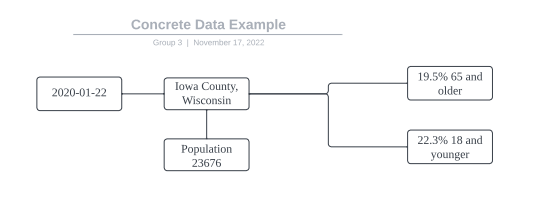

- Conceptual ER 

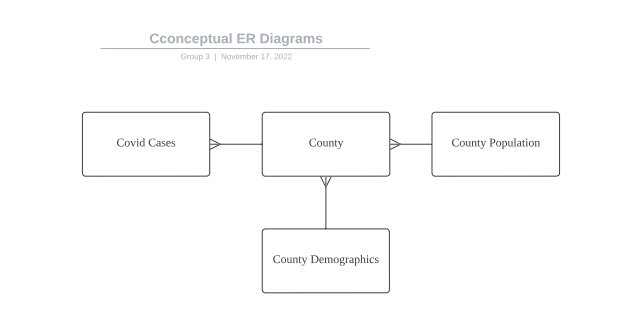

- Physical ER

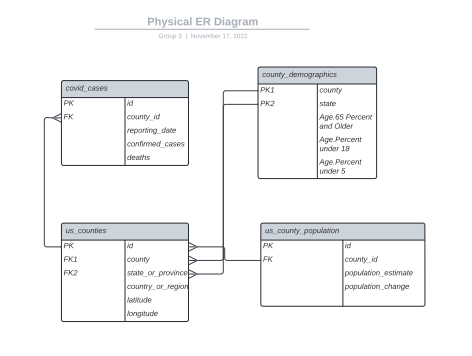

#### Sample tables
- us_county_population

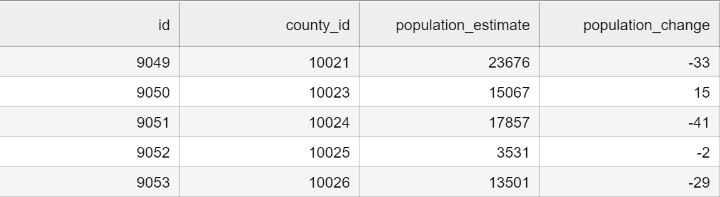

- us_counties

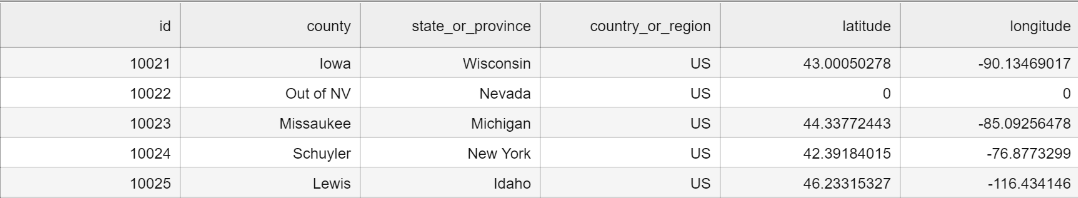

- county_demographics

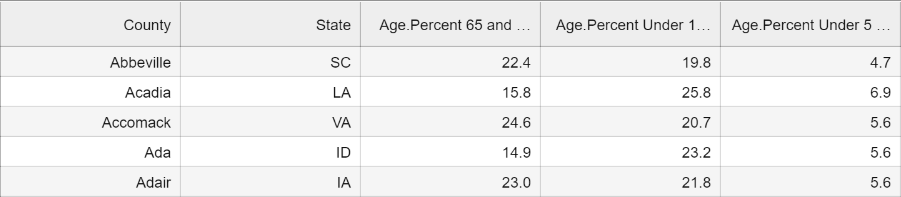

- covid_cases

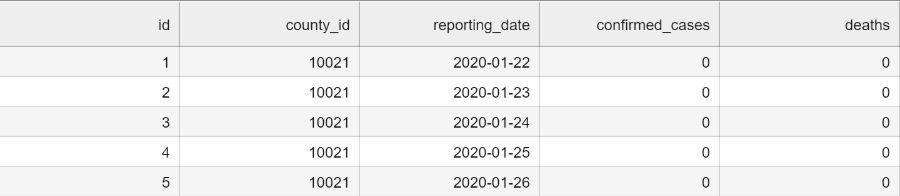


### SQL to create staging tables

```sql
-- First, have all the DROP TABLE IF EXISTS commands
DROP TABLE IF EXISTS staging.us_county_population;
DROP TABLE IF EXISTS staging.us_counties;
DROP TABLE IF EXISTS staging.county_demographics;
DROP TABLE IF EXISTS staging.covid_cases;


-- Then have all of the CREATE TABLE IF NOT EXISTS commands
CREATE TABLE IF NOT EXISTS staging.us_county_population
(
    id NUMERIC,
    county_id NUMERIC,
    population_estimate NUMERIC,
    population_change NUMERIC
);

CREATE TABLE IF NOT EXISTS staging.us_counties
(
  id NUMERIC,
  county TEXT,
  state TEXT,
  country TEXT,
  latitude NUMERIC,
  longitude NUMERIC
);

CREATE TABLE IF NOT EXISTS staging.county_demographics
(
  county TEXT,
  state TEXT,
  percent_above_65 NUMERIC,
  percent_under_18 NUMERIC,
  percent_under_5 NUMERIC
);

CREATE TABLE IF NOT EXISTS staging.covid_cases
(
  id NUMERIC,
  county_id NUMERIC,
  reporting_date DATE,
  confirmed_cases NUMERIC,
  deaths NUMERIC
);

CREATE TABLE IF NOT EXISTS staging.state_codes
(
  state TEXT,
  abbreviation TEXT
);
```

### Load script with \copy commands

```sql
TRUNCATE TABLE staging.covid_cases;

\copy staging.covid_cases  FROM '../../data/covid_cases.csv' WITH HEADER CSV;

TRUNCATE TABLE staging.county_demographics;

\copy staging.county_demographics  FROM '../../data/county_demographics.csv' WITH HEADER CSV;

TRUNCATE TABLE staging.us_counties;

\copy staging.us_counties  FROM '../../data/us_counties.csv' WITH HEADER CSV;

TRUNCATE TABLE staging.us_county_population;

\copy staging.us_county_population  FROM '../../data/us_county_population.csv' WITH HEADER CSV;

TRUNCATE TABLE staging.state_codes;

\copy staging.state_codes FROM '../../data/state_codes.csv' WITH HEADER CSV;
```


These files can be found by navigating to the `i320d/projects/covid/src/scripts` directory. They are run by the following commands in a terminal:

Creating staging tables:
- `bash create_staging_tables.sh`

Loading data into staging tables:
- `bash load_staging_data.sh`

## Data Transformation

### Transformation to Star Schema

#### Identify facts, grain, and dimensions

Within the COVID case data, each county reported their case and death data for each day within the time period. Thus, the quantitative facts that we are interested in when trying to answer the requirements are the cases and deaths reported. We are able to aggregate that case and death data with respect to data describing the counties, states, or nation using a star schema. This lends itself to what the grain of the data in our star schema is: a single day of COVID data for a particular county. 

Once considering the reported COVID data to be our facts, we create three dimensions:
- A dimension documenting the reporting date of the COVID data.
- A dimension representing county data, including the county name, state, and demographic data
- A dimension about county population, such as the total population of that county.

In doing so, we are able to transform the above tables into a star schema with a fact table and surrounding dimensions.

As an intermediary when trying to create the dimension describing the counties, we had to use a table `state_codes` in order to standardize the state name columns from the `us_counties` and `us_county_demographics` tables. This would enable them to be joined together.

#### Transformation diagram

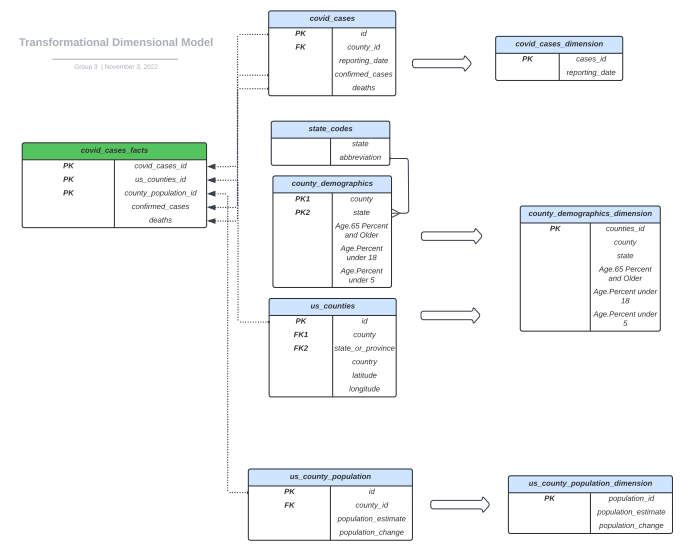

#### Documentation for star schema

- Examples of Concrete data (for the star schema)

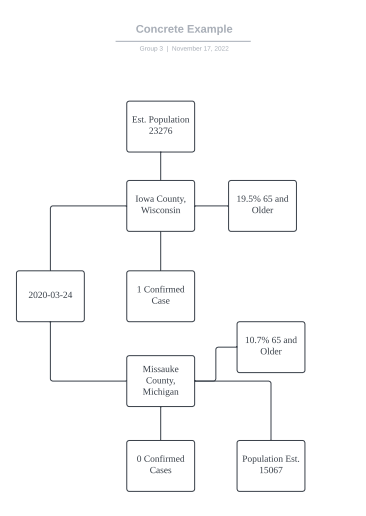

- Conceptual ER (for the star schema)

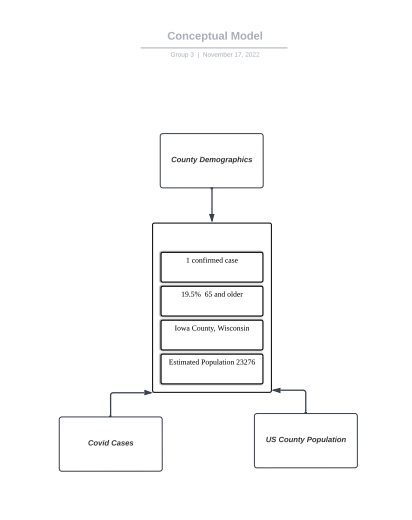

- Physical ER (for the star schema)

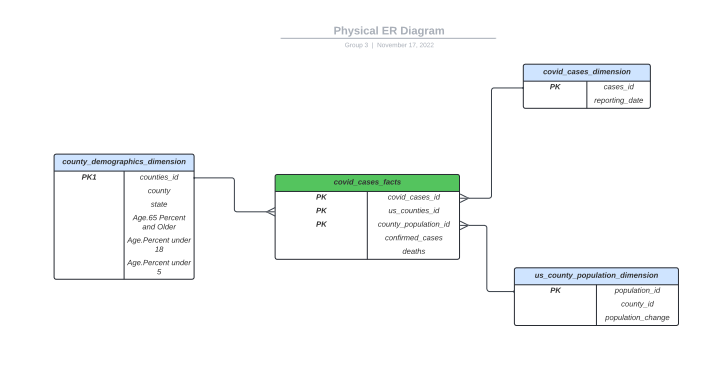

#### Sample tables
- covid_cases_facts

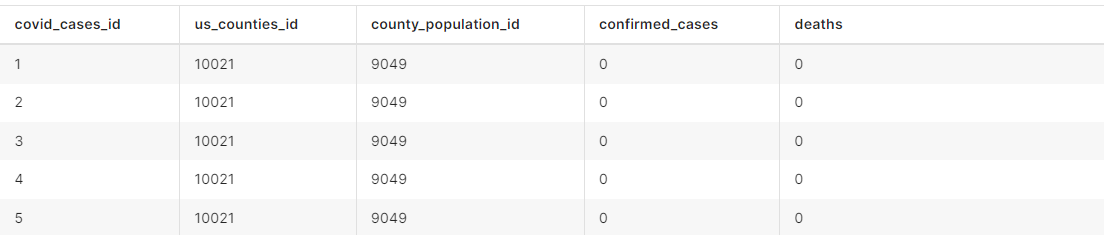

- county_demographics_dimension

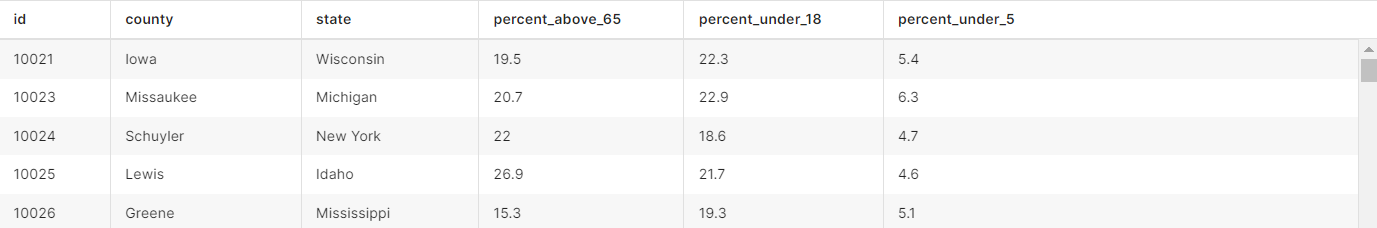

- covid_cases_dimension

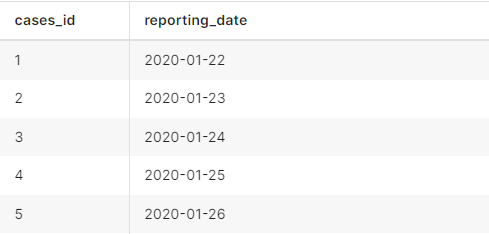

- us_county_population_dimension

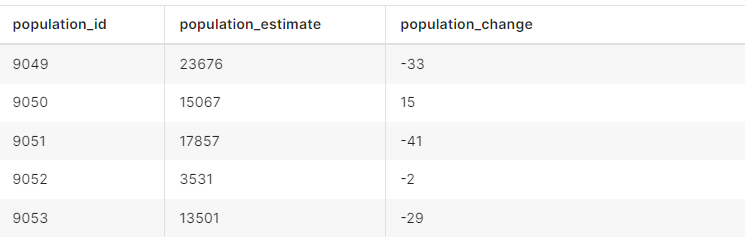

- state_codes

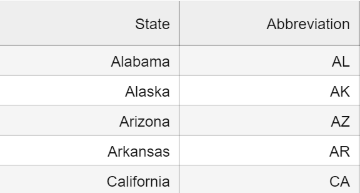


#### dbt models transforming to star schema

#### covid_cases_facts
```sql
{{ config(
    materialized="table"
) }}
SELECT covid.id AS covid_cases_id, 
       counties.id AS us_counties_id, 
       pop.id AS county_population_id,
       confirmed_cases,
       deaths
FROM staging.us_counties AS counties
JOIN staging.covid_cases AS covid ON covid.county_id = counties.id
JOIN staging.us_county_population AS pop ON pop.county_id = counties.id
```

#### county_demographics_dimension
```sql
{{ config(
    materialized="table"
) }}
SELECT counties.id, 
       d.county, 
       c.state, 
       percent_above_65, 
       percent_under_18, 
       percent_under_5 
FROM staging.county_demographics AS d
JOIN staging.state_codes c ON c.abbreviation = d.state 
JOIN staging.us_counties AS counties ON counties.county = d.county AND counties.state = c.state
```

#### covid_cases_dimension
```sql
{{ config(
    materialized="table"
) }}
SELECT id AS cases_id, 
       reporting_date
FROM staging.covid_cases
```

#### us_county_population_dimension
```sql
{{ config(
    materialized="table"
) }}

SELECT id AS population_id,
       population_estimate,
       population_change
FROM staging.us_county_population AS population
```

### Transformation to Data Products

#### Rationale for data products produced

Explain why you created the data products you chose to create; explain how these data products enable you to address your project requirements.

We created four data products to answer the requirements:
- `county_case_rate`:A county case rate, a time series documentation of each of the county's COVID cases per capita. 
- `state_case_rate`: A state case rate, similar to the county case rate product but this time presenting COVID data aggregated for the states rather than the counties.
- `time_series_demographics`: Another time series representation of the county case rate, with demographic data attached for each of the counties.
- `total_case_demographics`: An overall aggregation of COVID data for the counties and states across the entire time period.

These data products enabled us to answer the project requirements because they enable us to identify and filter COVID data within our grain. For example, we were able to view what counties reported for particular dates in order to see where cases highest or lowest for a given day. As a byproduct of creating these time series representations, we were also able to create time series plots that compared the COVID data of different groupings of factors, such as demographics.

#### dbt model files to create and load the data into your data product(s)

#### county_case_rate
```sql
{{ config(
    materialized="table"
) }}
SELECT reporting_date,
       c.id,
       c.county,
       c.state,
       confirmed_cases,
       population_estimate,
       confirmed_cases / population_estimate AS cases_per_capita,
       deaths
FROM {{ref ('covid_cases_facts')}} AS f
JOIN {{ref ('county_demographics_dimension')}} AS c ON c.id = f.us_counties_id
JOIN {{ref ('covid_cases_dimension')}} AS covid ON covid.cases_id = f.covid_cases_id
JOIN {{ref ('us_county_population_dimension')}} AS p on (p.population_id = f.county_population_id)
ORDER BY reporting_date
```

#### state_case_rate
```sql
{{ config(
    materialized="table"
) }}
SELECT reporting_date,
       c.state,
       SUM(confirmed_cases / population_estimate) AS cases_per_capita
FROM {{ref('covid_cases_facts')}} AS f
JOIN {{ref('county_demographics_dimension')}} AS c ON c.id = f.us_counties_id
JOIN {{ref('covid_cases_dimension')}} AS covid ON covid.cases_id = f.covid_cases_id
JOIN {{ref('us_county_population_dimension')}} AS p on p.population_id = f.county_population_id
GROUP BY reporting_date, c.state
ORDER BY cases_per_capita DESC
```

#### time_series_demographics
```sql
{{ config(
    materialized="table"
) }}
SELECT reporting_date,
       c.id,
       c.county,
       c.state,
       confirmed_cases / population_estimate AS cases_per_capita,
       percent_above_65,
       percent_under_18,
       percent_under_5,
       deaths
FROM {{ref('covid_cases_facts')}} AS f
JOIN {{ref('county_demographics_dimension')}} AS c ON c.id = f.us_counties_id
JOIN {{ref('covid_cases_dimension')}} AS covid ON covid.cases_id = f.covid_cases_id
JOIN {{ref('us_county_population_dimension')}} AS p on p.population_id = f.county_population_id 
ORDER BY cases_per_capita DESC
```

#### total_case_demographics
```sql
{{ config(
    materialized="table"
) }}
SELECT c.county,
       c.state,
       SUM(confirmed_cases / population_estimate) AS cases_per_capita,
       MAX(percent_above_65) AS percent_above_65,
       MAX(percent_under_18) AS percent_under_18,
       MAX(percent_under_5) AS percent_under_5
FROM {{ref ('covid_cases_facts')}} AS f
JOIN {{ref ('county_demographics_dimension')}} AS c ON c.id = f.us_counties_id
JOIN {{ref ('covid_cases_dimension')}} AS covid ON covid.cases_id = f.covid_cases_id
JOIN {{ref ('us_county_population_dimension')}} AS p on p.population_id = f.county_population_id 
GROUP BY county, state
ORDER BY cases_per_capita DESC
```

## Data Analysis and Visualization

### Addressing project requirements

## [Interactive Dashboard Here](https://superset.dei320.net/superset/dashboard/p/8ekGXpJGl3o/)

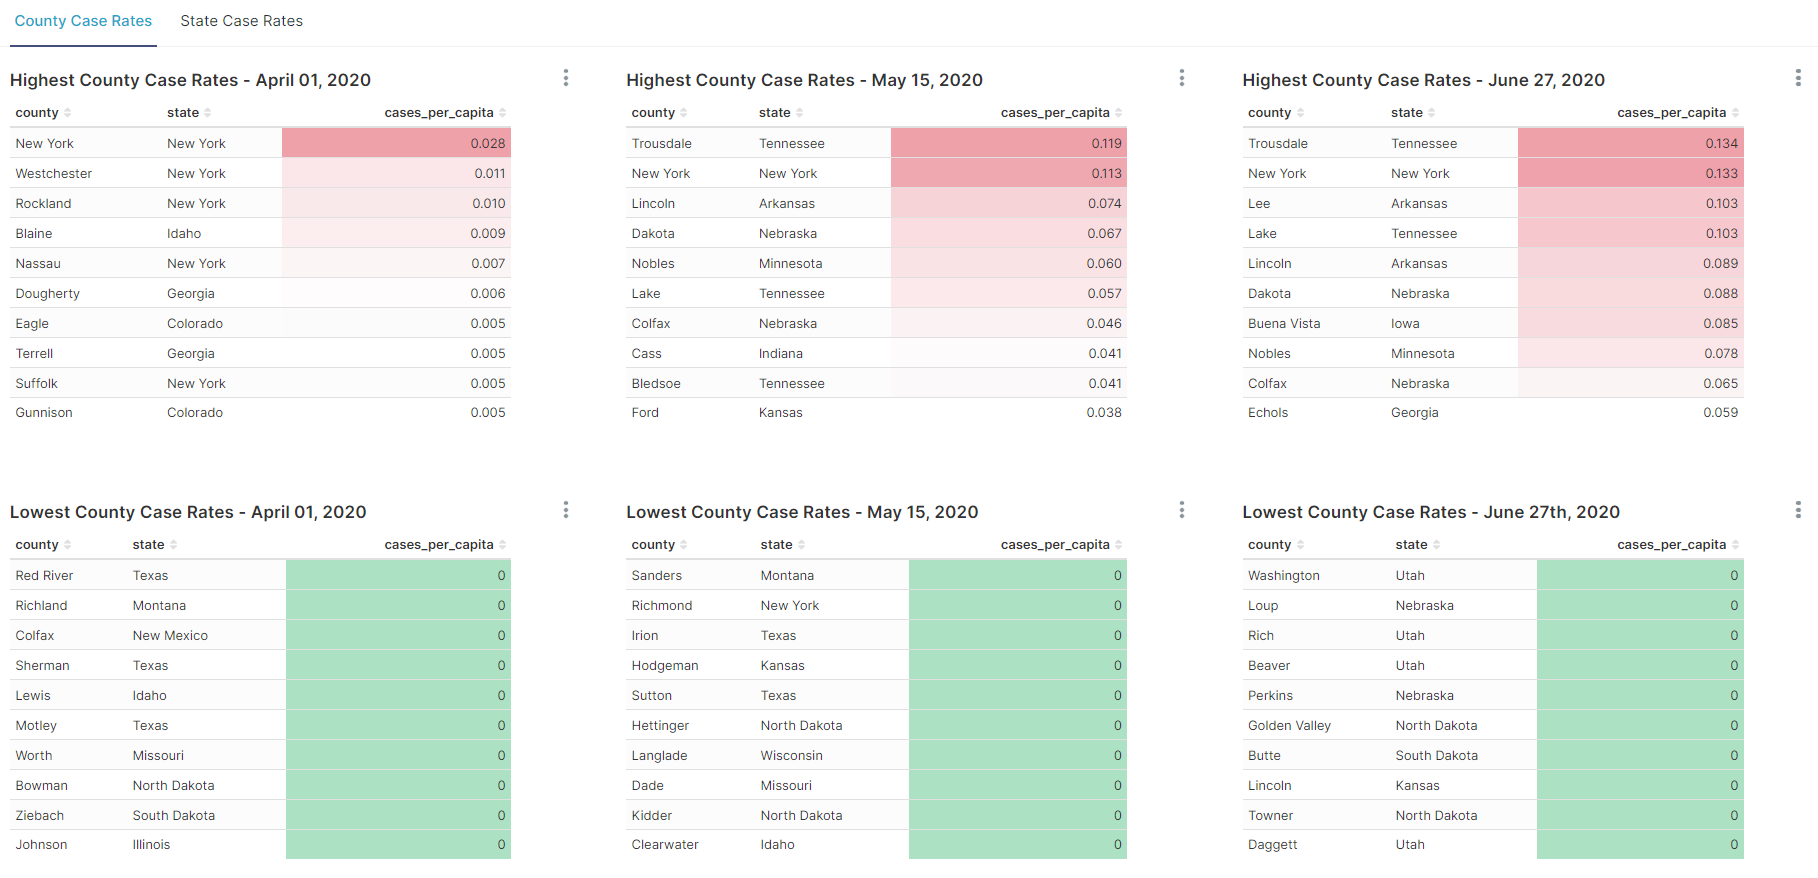

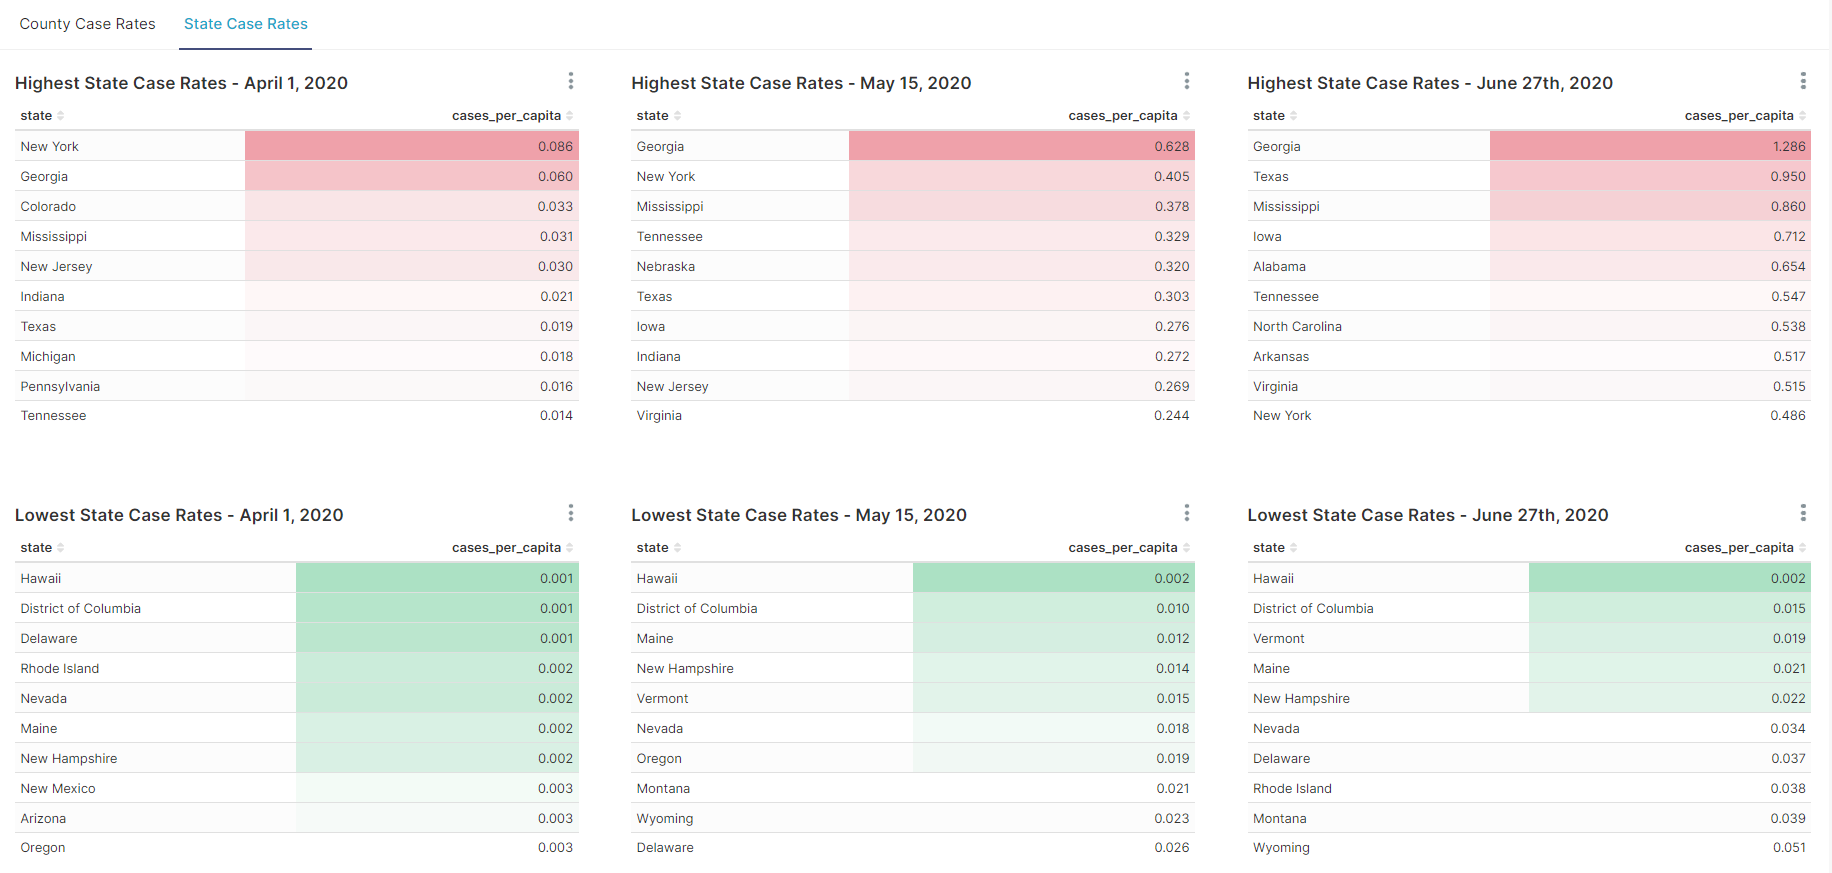

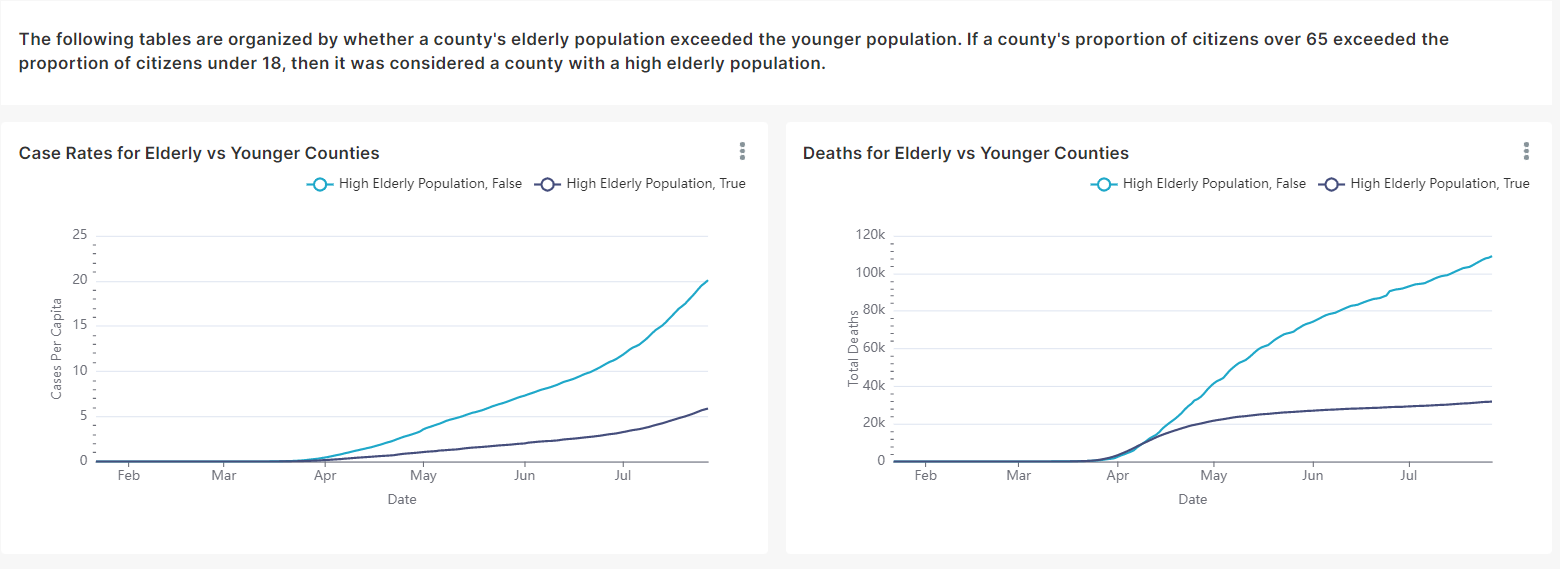

#### Identifying the counties and states with the highest and lowest case rates

The 12 tables provide snapshots of the three days that were listed within the project requirements. For each particular day, the top 10 highest and lowest case rates can be found on a county as well as a state level. 

#### Identifying whether counties with older populations experience higher case rates

The time series plot on the bottom left of the dashboard seeks to address this problem. While counties with high elderly populations did experience the impacts of COVID-19, counties that had a higher younger population saw higher cases per capita overall. Note that that there are a variety of potential confounders, such as the population of younger counties being higher.

#### Comparing the deaths in older and younger counties

The visualization in the bottom right indicates that while the number of deaths rate in the elderly counties at first matches the death rate in younger counties, overall counties with a higher younger population experienced a higher number of deaths. Again, this does not mean that there were more young individuals experiencing cases or dying; many elderly people were likely impacted within counties with young populations. 

Ultimately, given the demographic data available, we can conclude that while counties with high concentrations of elderly populations were indeed heavily impacted by the pandemic, the rest of the United States that did not have the elderly accounting for a majority of their demographics faced most of the cases and deaths.


## Document your visualization decisions

When trying to find the top 10 highest and lowest case rates for specific dates on a county level, we chose to use a simple table because we need to view pieces of data at the smallest grain (counties' COVID data on a specific date). By creating these tables and just including the county, state, and cases per capita, we are able to answer the requirement by sorting by cases per capita. We choose to use a color scheme where a higher case rate corresponds to red, and a low case rate corresponds to green. This should be intuitive in that a high case rate corresponding to red indicates negative news and green typically indicates good news. This same process applies to the second requirement about the states, except we simply aggregated the cases per capita for all the counties within a particular state to get the top 10 highest and lowest cases by state.

The main alias that we created within our data products to answer these questions was cases_per_capita, which required us to divide the number of cases reported in a county by the population of that county. This enables us to get a better overall view of the state of COVID within a county, rather than just using the raw cases reported, because counties have varying populations.

When comparing the health of counties with a high elderly population to counties without, we chose to use time series line plots because they enable us to get a more generalized view of the entire dataset, as well as how the growth rate of the cases and deaths changes over time. By grouping the dataset into two lines, the visualization also enables one to intuitively understand and compare the differences between counties with high elderly populations against those without.

## Reflection and challenges addressed

One challenge that we were faced with was how to transform the source tables into meaningful dimensions. For example, the `county_demographics` and `us_counties` tables both described counties, but were in separate tables. Instead of making them into two separate dimensions, we decided to join them into one, but needed the help of the external `state_code` table. This was an interesting learning experience because it allowed us to think about how the tables could be transformed into dimensions in different ways, as well as how that dimension would lend itself to answering research questions in the final product.

We also faced a data duplication issue that was present in the source data. For example, county names being the same as their state names caused duplicate entries to be created that trickled down into the data products. Having to re-run the data pipeline multiple times created a bit of tedium. 

Additionally, we also ran into some challenges in Superset while attempting to compare elderly and younger counties. To address this challenge, we utilized the custom SQL feature in the chart settings of Superset and wrote in a line of SQL code that helped us group the data into one group where the county’s population above 65 was greater than the population under 18 and a group where it was not. In implementing this adjustment, we were able to get a clean final visualization that we then used to help guide us in executing our own independent inquiry about the death rates. Overall, our group is most proud of just performing each stage of the data engineering process from beginning to end. We learned throughout the project that data engineering is very meticulous and detail-oriented work. Yet, it can ultimately be very satisfying to see the fruition of our team’s efforts fulfilled. 
